In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [18]:
def convert_time(x, y):
    return float(x) * y

def reshape_results(mode, df):
    df['unit_factor'] = np.where(df['unit'] == 's', 1000, 1)
    df['time_ms'] = df.apply(lambda row: convert_time(row['time'], row['unit_factor']), axis=1)
    mean_df = df.groupby(['mode', 'size', 'window_size', 'n_thread']) \
        .agg(mean_time=("time_ms", "mean"))\
        .reset_index()
    seq_df = mean_df[mean_df['mode'] == 's']
    par_df = mean_df[mean_df['mode'] == mode]
    par_df = par_df.merge(seq_df[['size', 'mean_time']], on='size', how='left')
    par_df['speedup'] = 1 /  (par_df['mean_time_x'] / par_df['mean_time_y'])
    return par_df

## Work Stealing analysis

In [19]:
with open('output_ps.txt') as f:
    lines = f.readlines()

split_lines = [x.split(" ") for x in lines]

df_list = []
for sl in split_lines:
    mode = sl[0]
    size = sl[1]
    window_size = sl[2]
    time = re.findall("\d+\.\d+", sl[3])[0]
    unit = "".join(re.findall("[a-z]", sl[3]))
    if len(sl) > 4:
        threads = sl[4][0]
    else:
        threads = 1

    df_list.append([mode, size, window_size, threads, time, unit])

df = pd.DataFrame(df_list, columns=['mode', 'size', 'window_size', 'n_thread', 'time', 'unit'])


In [20]:
ps_df = reshape_results(mode="ps", df=df)

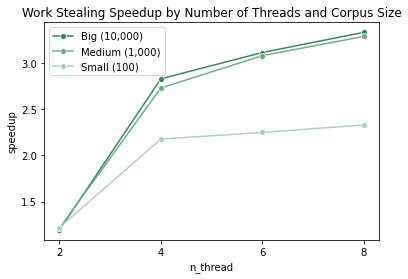

In [26]:
sns.lineplot(data=ps_df, x='n_thread', y='speedup', hue='size', marker="o", palette=sns.light_palette("seagreen", n_colors=4, reverse=True)[0:3]) \
    .set(title="Work Stealing Speedup by Number of Threads and Corpus Size")
plt.legend(labels=["Big (10,000)", 'Medium (1,000)', 'Small (100)'])

## Work Balancing analysis

In [21]:
with open('output_pb.txt') as f:
    lines = f.readlines()

split_lines = [x.split(" ") for x in lines]

df_list = []
for sl in split_lines:
    mode = sl[0]
    size = sl[1]
    window_size = sl[2]
    time = re.findall("\d+\.\d+", sl[3])[0]
    unit = "".join(re.findall("[a-z]", sl[3]))
    if len(sl) > 4:
        threads = sl[4][0]
    else:
        threads = 1

    df_list.append([mode, size, window_size, threads, time, unit])

df = pd.DataFrame(df_list, columns=['mode', 'size', 'window_size', 'n_thread', 'time', 'unit'])


In [22]:
pb_df = reshape_results(mode="pb", df=df)

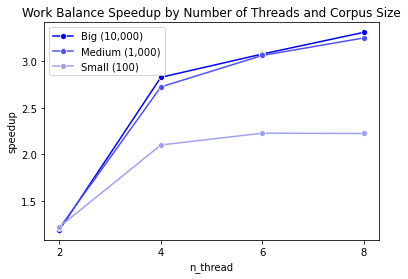

In [25]:
sns.lineplot(data=pb_df, x='n_thread', y='speedup', hue='size', marker="o", palette=sns.light_palette("blue", n_colors=4, reverse=True)[0:3]) \
    .set(title="Work Balance Speedup by Number of Threads and Corpus Size")
plt.legend(labels=["Big (10,000)", 'Medium (1,000)', 'Small (100)'])